In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm, trange

In [2]:
def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x，y：样本的值和类别
    ker：核函数，与线性回归中核函数的含义相同
    C：惩罚系数
    max_iter：最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
    b = 0
        
    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
    
    for l in trange(max_iter):
        # 开始迭代
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j，并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])
            
            # 用-q/2p更新alpha_i的值
            eta = K[j, j] + K[i, i] - 2 * K[i, j] # 分母
            e_i = np.sum(y * alpha * K[:, i]) + b - y[i] # 分子
            e_j = np.sum(y * alpha * K[:, j]) + b - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta / y[i] - C)
                upper = min(C, zeta / y[i])
            else:
                lower = max(0, zeta / y[i])
                upper = min(C, zeta / y[i] + C)
            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]
            
            # 更新b
            b_i = b - e_i - y[i] * (alpha_i - alpha[i]) * K[i, i] - y[j] * (alpha_j - alpha[j]) * K[i, j]
            b_j = b - e_j - y[j] * (alpha_j - alpha[j]) * K[j, j] - y[i] * (alpha_i - alpha[i]) * K[i, j]
            if 0 < alpha_i < C:
                b = b_i
            elif 0 < alpha_j < C:
                b = b_j
            else:
                b = (b_i + b_j) / 2
            
            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j

    return alpha, b

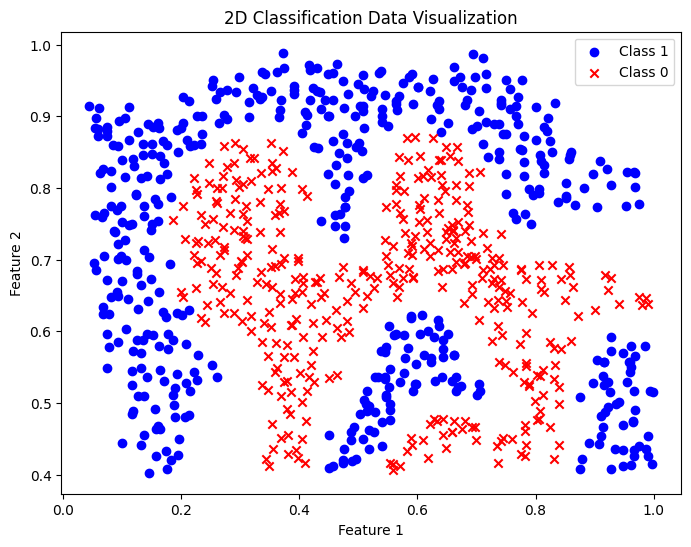

In [3]:
data = loadmat('../data/ex6data2.mat')
x = np.array(data['X'])
y = np.array(data['y']).astype(int)
y[y == 0] = -1
y = y.flatten()

# 可视化数据
plt.figure(figsize=(8, 6))
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='blue', marker='o', label='Class 1')
plt.scatter(x[y == -1][:, 0], x[y == -1][:, 1], color='red', marker='x', label='Class 0')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Classification Data Visualization')
plt.legend()
plt.show()

In [4]:
def simple_poly_kernel(d):
    def k(x, y): 
        return np.inner(x, y) ** d
    return k

# RBF核
def rbf_kernel(sigma):
    def k(x, y):
        return np.exp(-np.inner(x - y, x - y) / (2.0 * sigma ** 2))
    return k

# 余弦相似度核
def cos_kernel(x, y):
    norm_x = np.linalg.norm(x, 2)
    norm_y = np.linalg.norm(y, 2)
    
    if norm_x > 0 and norm_y > 0:
        return np.inner(x, y) / (norm_x * norm_y)
    else:
        return 0

# sigmoid核
def sigmoid_kernel(beta, c):
    def k(x, y):
        return np.tanh(beta * np.inner(x, y) + c)
    return k

核函数： Poly(3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:17<00:00, 11.44it/s]


核函数： RBF(0.1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:40<00:00, 12.50it/s]


核函数： Cos


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:21<00:00, 11.33it/s]


核函数： Sigmoid(1,-1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:06<00:00, 11.73it/s]


<Figure size 640x480 with 0 Axes>

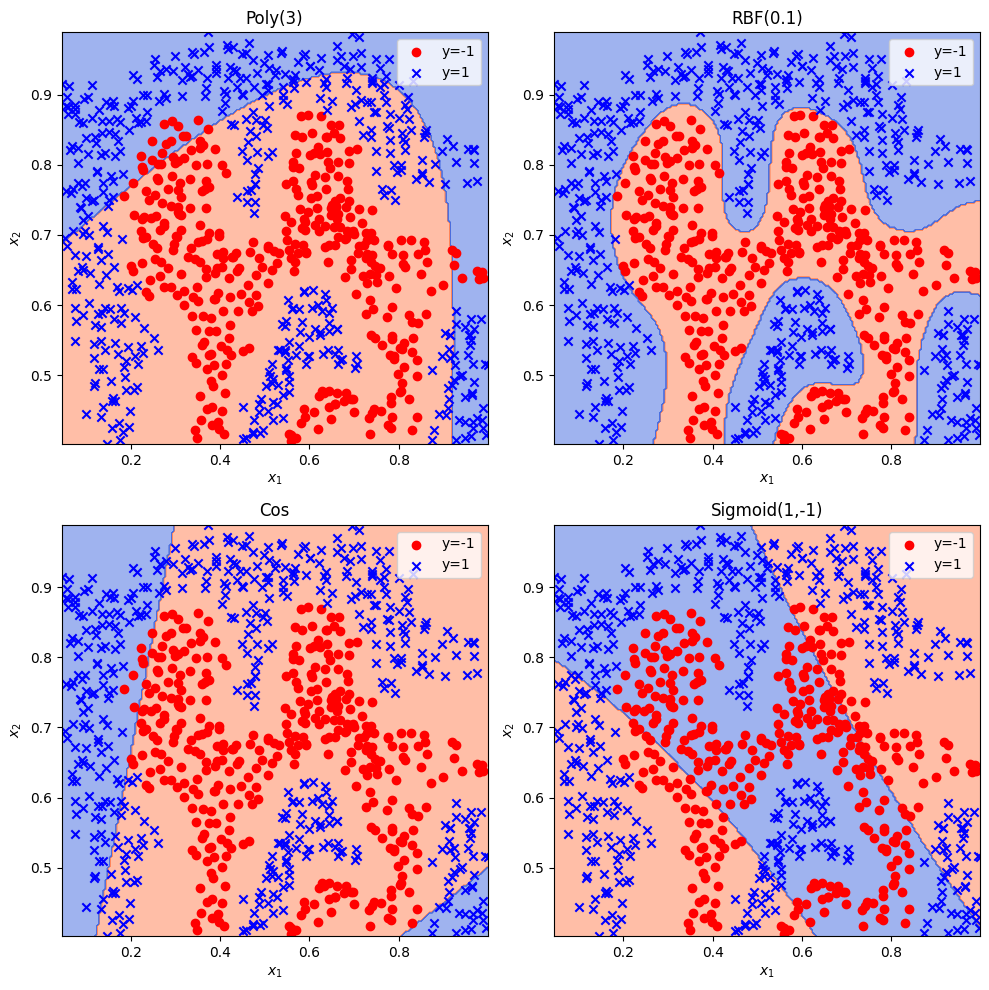

In [5]:
kernels = [
    simple_poly_kernel(3), 
    rbf_kernel(0.1), 
    cos_kernel, 
    sigmoid_kernel(1, -1)
]
ker_names = ['Poly(3)', 'RBF(0.1)', 'Cos', 'Sigmoid(1,-1)']
C = 100
max_iter = 5000

# 绘图准备，构造网格
np.random.seed(0)
plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
cmap = ListedColormap(['coral', 'royalblue'])

# 开始求解 SVM
for i in range(len(kernels)):
    print('核函数：', ker_names[i])
    alpha, b = SMO(x, y, kernels[i], C=C, max_iter=max_iter)
    sup_idx = alpha > 1e-6 # 支持向量的系数不为零
    sup_x = x[sup_idx] # 支持向量
    sup_y = y[sup_idx]
    sup_alpha = alpha[sup_idx]

    # 用支持向量计算 w^T*x
    def wx(x_new):
        s = 0
        for xi, yi, ai in zip(sup_x, sup_y, sup_alpha):
            s += yi * ai * kernels[i](xi, x_new)
        return s
        
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    Gx, Gy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # 将网格转换为标准形式
    X_grid = np.array([Gx.ravel(), Gy.ravel()]).T 
    Y_grid = np.array([wx(xi) + b for xi in X_grid])
    Y_grid[Y_grid < 0] = -1
    Y_grid[Y_grid >= 0] = 1
    Y_grid = Y_grid.reshape(Gx.shape)

    # 绘制决策边界和数据点
    axs[i].contourf(Gx, Gy, Y_grid, cmap=cmap, alpha=0.5)
    axs[i].scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
    axs[i].scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
    axs[i].set_title(ker_names[i])
    axs[i].set_xlabel(r'$x_1$')
    axs[i].set_ylabel(r'$x_2$')
    axs[i].legend()


plt.tight_layout()
plt.show()

核函数： Poly(3)
核函数： RBF
核函数： Sigmoid


<Figure size 1500x500 with 0 Axes>

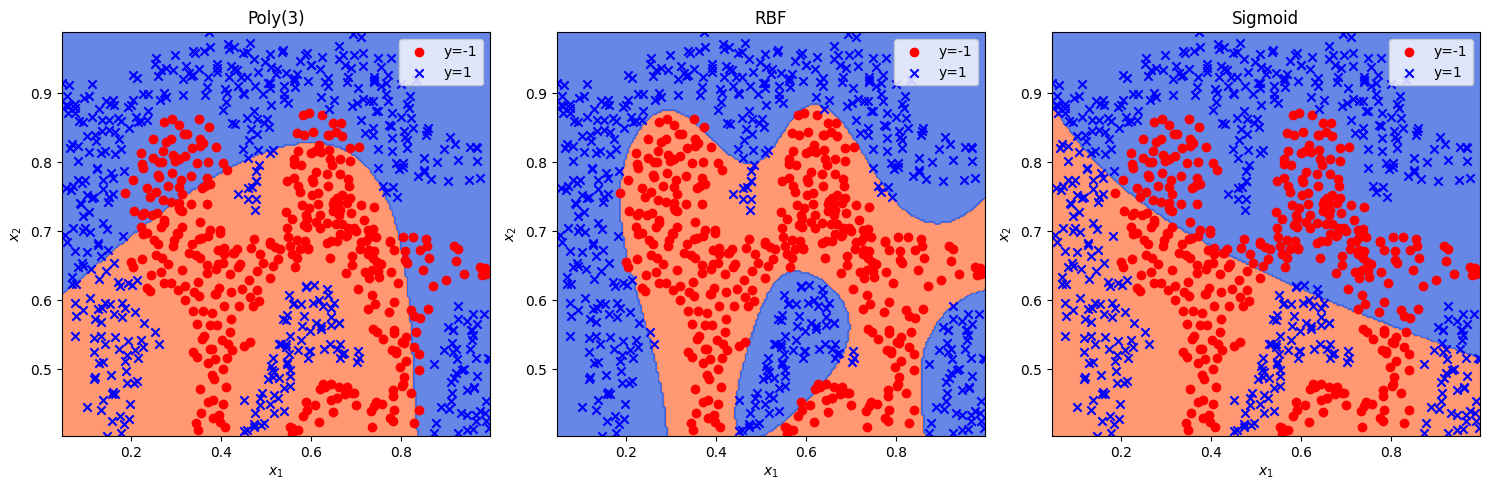

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap


kernels = ['poly', 'rbf', 'sigmoid']  # cos核在scikit-learn中不可用
ker_names = ['Poly(3)', 'RBF', 'Sigmoid']
C = 100

# 绘图准备
np.random.seed(0)
plt.figure(figsize=(15, 5))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1行3列的子图布局
cmap = ListedColormap(['coral', 'royalblue'])

# SVM和决策边界
for i, kernel in enumerate(kernels):
    print('核函数：', ker_names[i])
    model = SVC(kernel=kernel, C=C, degree=3)  # 对于多项式核，设置degree=3
    model.fit(x, y)

    # 根据数据的实际范围调整图的范围
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axs[i].contourf(xx, yy, Z, cmap=cmap, alpha=0.8)
    axs[i].scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
    axs[i].scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
    axs[i].set_title(ker_names[i])
    axs[i].set_xlabel(r'$x_1$')
    axs[i].set_ylabel(r'$x_2$')
    axs[i].legend()

plt.tight_layout()
plt.show()